In [38]:
import os
import sys
import numpy as np

import time
import json
import yaml
import pickle
import math
import shutil
import hydra

from tqdm import tqdm
from datetime import datetime
from omegaconf import DictConfig, OmegaConf
from collections import defaultdict, Counter

import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

from datasets.dataset import LaserImageDataset, get_transforms
from datasets.preprocess import generate_html
from models.network import Network

from utils.metrics import MetricLogger
from utils.misc import create_new_dir, copy_src, save_file
from utils.utils import set_random_seed, model_parameters

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Specify the experiment to evaluate

In [2]:
exp_dir = 'session001/exp1_PointCNN_Grating_A6_Grating_SON1_LASEROPTIK_LASEROPTIK_SON1_seed3061994_lr0.0003_e500_b64'
print("Evaluating exp :", exp_dir)

log_dir = "../logs/" + exp_dir
ckpt_dir = log_dir + "/checkpoints"

if not os.path.exists(log_dir):
    raise Exception(f"{log_dir} doesn't exists")


Evaluating exp : session001/exp1_PointCNN_Grating_A6_Grating_SON1_LASEROPTIK_LASEROPTIK_SON1_seed3061994_lr0.0003_e500_b64


## Load cfg 

In [3]:
# load config
cfg = OmegaConf.load(log_dir + '/cfg.yaml')
print(OmegaConf.to_yaml(cfg))

seeds:
- 3061994
task: classification
num_classes: 2
net:
  type: PointCNN
  hidden_dim: 512
  out_dim: 512
loss:
  bce_loss:
    weight: 1.0
    learn_weight: false
  mse_loss:
    weight: 0.0
    learn_weight: false
optim:
  lr: 0.0003
  lr_min: 1.0e-06
  lr_scheduler: reduceonplateau
  warmup_epochs: 0
  lr_patience: 10
  lr_reduce_factor: 0.9
  lr_adjust: false
  lr_adjust_rule: ''
  weight_decay: 0
  weight_decay_end: 1.0
  clip_grad: 1.0
data:
  img_height: 480
  img_width: 480
  n_channels: 1
  aug_photo: 0.0
  aug_geome: 0.5
  data_dir: ../data/near_field
  datasets:
  - Grating_A6
  - Grating_SON1
  - LASEROPTIK
  - LASEROPTIK_SON1
  val_split: 0.4
  prefetch: 1
train:
  session: 1
  epochs: 500
  batch_size: 64
  num_workers: 1
  gpu: 0
  ddp: false
  dist_run: false
  resume_training: false
  single_batch: false
  debug: false
  early_stop_metric: val/acc
  early_stop_patience: 20
  eval_interval: 10
  log_interval: 100
  n_images: 20
  eval_metric: val/acc
  train_skip_fram

## Load model from checkpoint

In [4]:
ckpt_name = 'best_acc'
print("Loading Checkpoint from ", ckpt_dir + '/' + ckpt_name)
network = Network(cfg)
print(network)

states = torch.load(ckpt_dir + '/' + ckpt_name + '.pth')
if ckpt_name == 'model_states':
    states = states['model_state']

network.load_state_dict(states, strict=True)
network = network.eval()
print("Model loaded sucessfully!")

Loading Checkpoint from  ../logs/session001/exp1_PointCNN_Grating_A6_Grating_SON1_LASEROPTIK_LASEROPTIK_SON1_seed3061994_lr0.0003_e500_b64/checkpoints/best_acc
Network(
  (net): PointCNN(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (res1_conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (res1_conv2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (res1_conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (res2_conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (res2_conv2): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
    (res2_conv3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (res2_

## Create dataloader

In [5]:
cfg.data.datasets = ['THALES_SESO_A']
cfg.data.prefetch = False
cfg.data.val_split = 1
eval_dataset = LaserImageDataset(cfg.data,
                                phase='val',
                                img_transform=get_transforms(cfg.data, "val"),
                                num_classes=cfg.num_classes,
                                balanced_class=False,
                                shuffle_labels=False,
                                )

eval_dataloader = DataLoader(eval_dataset, batch_size=1, shuffle=False, num_workers=1)

print(f"Evaluation samples: {len(eval_dataset)}, Bathces: {len(eval_dataloader)}")


Splitting THALES_SESO_A labels into train and validaton set
Class 0: 6503/8100 val samples
Class 1: 1597/8100 val samples
Evaluation samples: 8100, Bathces: 8100


## Prepare 

In [6]:
set_random_seed(cfg.exp.seed)

device = torch.device("cuda:0")
network = network.to(device)

date_time = datetime.now().strftime("%d%m%Y")
# date_time = datetime.now().strftime("%d%m%Y_%H%M%S")

result_dir = log_dir + f"/evaluations/{date_time}_{'_'.join(cfg.data.datasets)}"

In [25]:
#! pip install scikit-learn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Evaluate

100%|██████████| 8100/8100 [00:36<00:00, 220.82it/s, 1.000000]

Metric           tp       fp       tn       fn       accuracy    precision
---------------  -------  -------  -------  -------  ----------  -----------
binary_accuracy  1587.00  117.00   6386.00  10.00    0.98        0.99
-------          -------  -------  -------  -------  -------     -------
Accuracy: 0.984320987654321, Precision:0.982008303859757, Recall: 0.9984365228267668


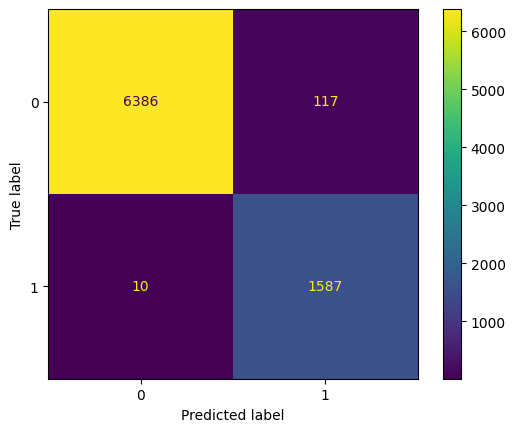

100%|██████████| 8100/8100 [00:54<00:00, 220.82it/s, 1.000000]

In [39]:
from utils.metrics import MetricLogger
from torchmetrics.classification import BinaryAccuracy
# eval_metrics = BinaryAccuracy().to(device)

eval_metrics = MetricLogger()

eval_results = [] 
acc_list = []
pred_labels = []
gt_labels = []
pbar = tqdm(total=len(eval_dataloader), position=0)
with torch.no_grad():
    for iter, batch in enumerate(eval_dataloader):
        pbar.update(1)

        imgs, labels, img_files = batch

        imgs = imgs.to(device)
        labels = labels.to(device)

        preds = network(imgs)
        # preds = F.softmax(preds, dim=-1)
        # print(labels)
        pred_labels.append(preds.cpu().numpy())
        gt_labels.append(labels.cpu().numpy())
        
        
        acc = eval_metrics(preds.argmax(-1).to(device), labels.argmax(-1).to(device))
        # acc = eval_metrics.update(preds.to(device), labels.to(device))

        for f, l, p in zip(img_files, labels, preds):
            eval_results.append(dict(img=f, label=l.argmax().item(), pred=p.argmax().item(), prob=p.max().item()))
            
        pbar.set_postfix_str(f"{acc:03f}")
        # break

eval_metrics.compute()

cm = confusion_matrix([l.argmax() for l in gt_labels], [l.argmax() for l in pred_labels])
print(f"Accuracy: {(6386+1587)/(6386+1587+117+10)}, Precision:{(6386)/(6386+117)}, Recall: {(6386)/(6386+10)}")
ConfusionMatrixDisplay(cm, display_labels=[0,1]).plot()

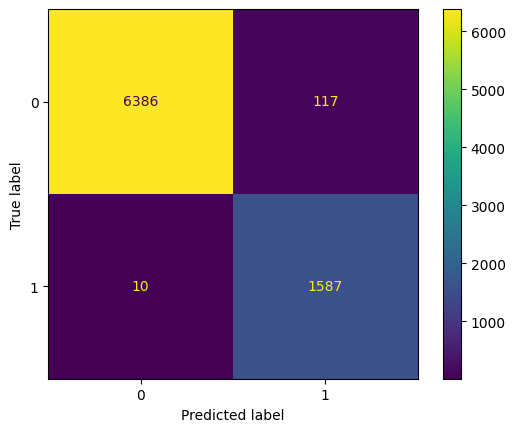

'Accuracy: 0.984320987654321, Precision:0.982008303859757, Recall: 0.9984365228267668'

## Save results to HTML

In [8]:
data_dir = os.path.join(os.getcwd(), "../data/near_field/images/")

html_data = generate_html(eval_results, data_dir, title='Eval Results')
save_file(f'{log_dir}/eval_results.html', html_data)

In [37]:
eval_metrics.compute()

tensor(0.9843, device='cuda:0')

100%|██████████| 8100/8100 [01:00<00:00, 182.24it/s, 1.000000]